# LLC Design Sweeper - Demo (P2)

This notebook demonstrates the parameter sweep and design process for a Half-Bridge LLC Resonant Converter.

## 1. Setup
Import the library.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from llc_sweeper.models import LLCSpecs
from llc_sweeper.sweeper import sweep_design, get_diverse_candidates
from llc_sweeper.plotting import plot_gain_curves
from llc_sweeper.sweeper import solve_fN
from llc_sweeper.equations import gain_fha, calculate_stress_full, calculate_required_deadtime

## 2. Define Specifications
Using the example values from the Article.

In [2]:
specs = LLCSpecs(
    Vin=400,        # Input Voltage (V)
    Vout=48,        # Output Voltage (V)
    Pout=600,       # Output Power (W)
    fR_target=100e3,# Resonant Frequency (Hz)
    fsw_min=50e3,   # Min Switching Freq (Hz)
    Coss=80e-12,    # MOSFET Output Capacitance (F)
    deadtime=2e-6,  # Deadtime (s)
    Ln_min=4.0, Ln_max=10.0,
    Qe_min=0.33, Qe_max=0.5
)
print("Specs defined.")

Specs defined.


## 3. Run Sweep
Sweep across Ln [4, 10] and Qe [0.33, 0.5].

In [3]:
results = sweep_design(specs)
print(f"Found {len(results)} valid candidates.")

Found 560 valid candidates.


## 4. Top Candidates
List the top 3 **diverse** scored designs.

In [4]:
top_candidates = get_diverse_candidates(results, top_n=3)

for i, res in enumerate(top_candidates):
    t = res.tank
    print(f"\nCandidate #{i+1} (Score: {res.score:.4f})  Valid: {len(res.warnings)==0}")
    print(f"  Ln={t.Ln_real:.2f}, Qe={t.Qe_real:.3f}, fN={res.fN:.3f}")
    print(f"  Components: n={t.n_used}, Lr={t.Lr*1e6:.1f}uH, Cr={t.Cr*1e9:.1f}nF, Lm={t.Lm*1e6:.1f}uH")
    print(f"  Stress: ILR_RMS={res.Ilr_rms:.2f}A, VCR_PK={res.Vcr_peak:.1f}V")
    print(f"    Primary: ILR_pk={res.Ilr_peak:.2f}A, ILM_pk={res.Ilm_peak:.2f}A, ILM_rms={res.Ilm_rms:.2f}A")
    print(f"    Switches (Q1,Q2): IQ_pk={res.Iq_peak:.2f}A, IQ_rms={res.Iq_rms:.2f}A")
    print(f"    Rectifiers (Q3,Q4): IQ_pk={res.Id_peak:.2f}A, IQ_rms={res.Id_rms:.2f}A")
    if res.warnings:
        print(f"  Warnings: {res.warnings}")


Candidate #1 (Score: 1.5608)  Valid: True
  Ln=10.07, Qe=0.367, fN=1.213
  Components: n=4, Lr=29.0uH, Cr=87.0nF, Lm=292.0uH
  Stress: ILR_RMS=2.63A, VCR_PK=256.1V
    Primary: ILR_pk=3.73A, ILM_pk=1.35A, ILM_rms=0.96A
    Switches (Q1,Q2): IQ_pk=3.73A, IQ_rms=1.86A
    Rectifiers (Q3,Q4): IQ_pk=19.63A, IQ_rms=9.82A

Candidate #2 (Score: 1.5616)  Valid: True
  Ln=10.08, Qe=0.330, fN=1.224
  Components: n=4, Lr=26.0uH, Cr=96.0nF, Lm=262.0uH
  Stress: ILR_RMS=2.67A, VCR_PK=250.8V
    Primary: ILR_pk=3.78A, ILM_pk=1.49A, ILM_rms=1.05A
    Switches (Q1,Q2): IQ_pk=3.78A, IQ_rms=1.89A
    Rectifiers (Q3,Q4): IQ_pk=19.63A, IQ_rms=9.82A

Candidate #3 (Score: 1.5633)  Valid: True
  Ln=10.06, Qe=0.404, fN=1.203
  Components: n=4, Lr=32.0uH, Cr=79.0nF, Lm=322.0uH
  Stress: ILR_RMS=2.61A, VCR_PK=261.6V
    Primary: ILR_pk=3.69A, ILM_pk=1.24A, ILM_rms=0.88A
    Switches (Q1,Q2): IQ_pk=3.69A, IQ_rms=1.84A
    Rectifiers (Q3,Q4): IQ_pk=19.63A, IQ_rms=9.82A


## 5. Gain Curves
Visualizing the gain response. The plot now automatically scales to show the full curve.

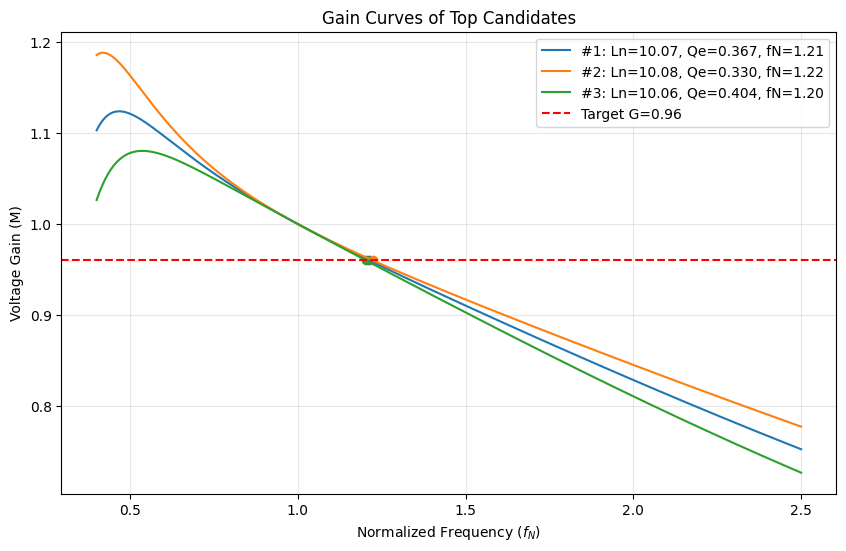

In [5]:
plot_gain_curves(top_candidates, top_n=3)
plt.show()

## 6. Adjusting for Resonance ($f_N=1$)

You may notice that the operating points are not exactly at $f_N = 1.0$. This is primarily due to the rounding of the transformer turns ratio ($n$) to an integer.

Ideally, $M_{req} = \frac{2 n V_{out}}{V_{in}}$. At resonance ($M=1$), we need $V_{in} = 2 n V_{out}$.

Let's take the best candidate and calculate the **adjusted Input Voltage** required to run exactly at resonance.

Current Design:
  Vin=400V, n_calculated=4.17, n_used=4
  Operating fN=1.213, Gain=0.960

To achieve fN=1.0 (Resonance) with n=4:
  Required Vin = 2 * 4 * 48 = 384.0 V

Verified Operating Point at Vin=384.0V:
  fN=1.000 (Should be 1.000)
  New fsw=100.20 kHz

--- Recalculated Stresses (At Resonance) ---
  Primary RMS Current (ILR): 2.71 A (vs 2.63 A)
  Magnetizing RMS (ILM):     1.16 A (vs 0.96 A)
  Peak Cap Voltage (VCr):    262.1 V (vs 256.1 V)


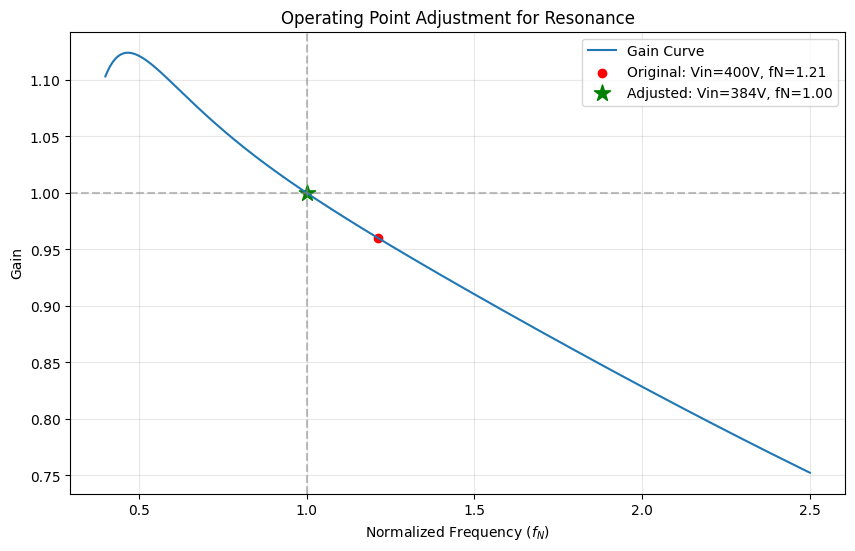

In [6]:
# Take the best candidate
best = top_candidates[0]

# Calculate Ideal Vin for Gain=1 with the USED integer n
n_used = best.tank.n_used
Vin_ideal = 2 * n_used * specs.Vout

print(f"Current Design:")
print(f"  Vin={specs.Vin}V, n_calculated={best.tank.n_float:.2f}, n_used={n_used}")
print(f"  Operating fN={best.fN:.3f}, Gain={best.gain:.3f}")
print(f"\nTo achieve fN=1.0 (Resonance) with n={n_used}:")
print(f"  Required Vin = 2 * {n_used} * {specs.Vout} = {Vin_ideal:.1f} V")

# Re-solve fN for this specific tank at Vin_ideal
target_gain_new = 1.0 # By definition
fN_new = solve_fN(target_gain_new, best.tank.Ln_real, best.tank.Qe_real)

# Recalculate Stresses for Adjusted Vin
# fsw corresponding to fN=1.0 is exactly the resonant frequency fR
fsw_new = best.tank.fR_real 

new_stress = calculate_stress_full(
    Vin=Vin_ideal, 
    Vout=specs.Vout, 
    Pout=specs.Pout, 
    n=best.tank.n_used, 
    Lm=best.tank.Lm, 
    Lr=best.tank.Lr, 
    Cr=best.tank.Cr, 
    fsw=fsw_new
)

print(f"\nVerified Operating Point at Vin={Vin_ideal:.1f}V:")
print(f"  fN={fN_new:.3f} (Should be 1.000)")
print(f"  New fsw={fsw_new/1000:.2f} kHz")

print("\n--- Recalculated Stresses (At Resonance) ---")
print(f"  Primary RMS Current (ILR): {new_stress['Ilr_rms']:.2f} A (vs {best.Ilr_rms:.2f} A)")
print(f"  Magnetizing RMS (ILM):     {new_stress['Ilm_rms']:.2f} A (vs {best.Ilm_rms:.2f} A)")
print(f"  Peak Cap Voltage (VCr):    {new_stress['Vcr_peak']:.1f} V (vs {best.Vcr_peak:.1f} V)")

# Plot Comparison
plt.figure(figsize=(10, 6))
fN_range = np.linspace(0.4, 2.5, 500)
curve = gain_fha(fN_range, best.tank.Ln_real, best.tank.Qe_real)

plt.plot(fN_range, curve, label='Gain Curve')
plt.scatter([best.fN], [best.gain], color='red', label=f'Original: Vin={specs.Vin}V, fN={best.fN:.2f}')
plt.scatter([fN_new], [1.0], color='green', marker='*', s=150, label=f'Adjusted: Vin={Vin_ideal:.0f}V, fN={fN_new:.2f}')

plt.axhline(1.0, linestyle='--', color='gray', alpha=0.5)
plt.axvline(1.0, linestyle='--', color='gray', alpha=0.5)
plt.xlabel('Normalized Frequency ($f_N$)')
plt.ylabel('Gain')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Operating Point Adjustment for Resonance')
plt.autoscale(enable=True, axis='y')
plt.show()

## 7. Final Design Summary
Summary of the recommended design parameters and operating conditions (Adjusted for Resonance).

In [7]:
from IPython.display import display, Markdown

# Calculate Required Deadtime using new Lm (Equation reverse check)
t_dead_req = calculate_required_deadtime(best.tank.Lm, specs.Coss, specs.fsw_min)

data = {
    "Parameter": [
        "Input Voltage (Vin)", "Output Voltage (Vout)", "Output Power (Pout)",
        "Transformer Ratio (n)", "Resonant Inductor (Lr)", "Resonant Capacitor (Cr)", "Magnetizing Inductor (Lm)",
        "Switching Frequency (fsw)", "Normalized Freq (fN)", "Quality Factor (Qe)", "Inductance Ratio (Ln)",
        "Primary RMS Current (ILR)", "Magnetizing RMS (ILM)", "Resonant Cap Peak (VCr)",
        "Pri Switch RMS (IQ)", "Sec Diode RMS (ID)",
        "Req Deadtime (ZVS)"
    ],
    "Value": [
        f"{Vin_ideal:.1f} V", f"{specs.Vout:.1f} V", f"{specs.Pout:.1f} W",
        f"{best.tank.n_used}", f"{best.tank.Lr*1e6:.1f} uH", f"{best.tank.Cr*1e9:.1f} nF", f"{best.tank.Lm*1e6:.1f} uH",
        f"{fsw_new/1000:.2f} kHz", f"{fN_new:.3f}", f"{best.tank.Qe_real:.3f}", f"{best.tank.Ln_real:.2f}",
        f"{new_stress['Ilr_rms']:.2f} A", f"{new_stress['Ilm_rms']:.2f} A", f"{new_stress['Vcr_peak']:.1f} V",
        f"{new_stress['Iq_rms']:.2f} A", f"{new_stress['Id_rms']:.2f} A",
        f"{t_dead_req*1e6:.3f} us (Max {specs.deadtime*1e6:.1f})"
    ]
}

df = pd.DataFrame(data)
display(Markdown("### Final Design Data Sheet"))
display(df)

### Final Design Data Sheet

,Parameter,Value
0,Input Voltage (Vin),384.0 V
1,Output Voltage (Vout),48.0 V
2,Output Power (Pout),600.0 W
3,Transformer Ratio (n),4
4,Resonant Inductor (Lr),29.0 uH
5,Resonant Capacitor (Cr),87.0 nF
6,Magnetizing Inductor (Lm),292.0 uH
7,Switching Frequency (fsw),100.20 kHz
8,Normalized Freq (fN),1.000
9,Quality Factor (Qe),0.367
